In [1]:
import matplotlib.pyplot as plt
plt.style.use('rcparams.mplstyle')
import matplotlib as mpl
from matplotlib.backends.backend_pgf import FigureCanvasPgf
mpl.backend_bases.register_backend('pdf', FigureCanvasPgf)
import numpy as np
import os
import pickle
from pycbc.filter import sigmasq
from calcwf import chirp2total, gen_wf, shifted_e_approx, shifted_e, ceiltwo, gen_psd

Only loading in here, still need to add generating code (and therefore rerun with 'correct' shifted_e and any other code changes). Of course also need to figure out what we want to use for degeneracy line equation as well! At the moment still using old -14/3 version with shifted_e_approx(), which is obviously bad.

In [2]:
def favata_et_al_avg(given_e, given_chirp, e_vals, f_low=10, q=2):
    """
    Converts array of eccentricity values to chirp mass along a line of constant 
    effective chirp mass, as given by equation 1.1 in Favata et al. 
    https://arxiv.org/pdf/2108.05861.pdf.

    Parameters:
        given_e: Value of eccentricity for given point on line of constant effective chirp mass.
        given_chirp: Value of chirp mass for given point on line of constant effective chirp mass.
        e_vals: Frequency values to be converted.

    Returns:
        Converted chirp mass values.
    """

    # Generate waveform at given point to use in sigmasq
    h = gen_wf(f_low, given_e, chirp2total(given_chirp, q), q, 4096, 'TEOBResumS')
    h.resize(ceiltwo(len(h)))
    
    # Generate the aLIGO ZDHP PSD
    psd = gen_psd(h, f_low)

    # Calculate both integrals using sigmasq
    h = h.real().to_frequencyseries()
    ss = sigmasq(h, psd=psd, low_frequency_cutoff=f_low+3)
    ssff = sigmasq(h*h.sample_frequencies**(-7/3), psd=psd, low_frequency_cutoff=f_low+3)
    ssf = sigmasq(h*h.sample_frequencies**(-7/6), psd=psd, low_frequency_cutoff=f_low+3)

    # Use average frequency to evolve eccentricities
    avg_f = (ssff/ss-(ssf/ss)**2)**(-3/14)
    s_given_e = shifted_e_approx(avg_f, f_low, given_e)
    s_e_vals = shifted_e_approx(avg_f, f_low, e_vals)

    # Find effective chirp mass of given point
    eff_chirp = given_chirp/(1-(157/24)*s_given_e**2)**(3/5)

    # Convert to chirp mass values
    chirp_vals = eff_chirp*(1-(157/24)*s_e_vals**2)**(3/5)

    return chirp_vals

Load in and make e^2 against chirp plot here:

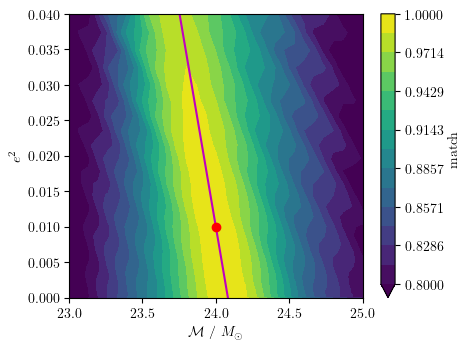

In [19]:
# Load data
with open(os.path.join('..', 'EccentricBinaries', 'notebooks', 'e_sqrd_chirp_data', 'dataslot_10'), 'rb') as fp:
        data = pickle.load(fp)[1][1]

# Axes
e_vals_10 = np.linspace(0, 0.2, 31)
chirp_vals_10 = np.linspace(23, 25, 31)

# Make plot
plt.figure(figsize=(0.75*6.4,0.75*4.8))
plt.contourf(chirp_vals_10, e_vals_10**2, data['quad'], np.linspace(0.8, 1, 15), vmin=0.8, vmax=1, extend='min')
plt.colorbar(label='match')
plt.scatter(24, 0.1**2, c='r', zorder=5)
xlims = plt.gca().get_xlim()
ylims = plt.gca().get_ylim()
plt.plot(favata_et_al_avg(0.1, 24, e_vals_10), e_vals_10**2, c='m')
# plt.scatter(favata_et_al_avg(0.1, 24, 0), 0, c='k', zorder=10, clip_on=False, marker='x', s=100)
plt.ylim(ylims)
plt.xlim(xlims)
plt.xlabel('$\mathcal{M}~/~M_\odot$')
plt.ylabel('$e^2$')
plt.tight_layout()